# Importálás

In [1]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
# Nlp library
import re
import nltk
from nltk.corpus import stopwords
import nltk as nlp
from sklearn.feature_extraction.text import CountVectorizer

# sklearn Library
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score
from sklearn.metrics import confusion_matrix, classification_report, plot_confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import explained_variance_score

#Tenserflow Library
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from keras.layers import LSTM
from tensorflow.keras.layers import Embedding,  Bidirectional
from tensorflow.keras.preprocessing.sequence import pad_sequences

import warnings
warnings.filterwarnings("ignore")

C:\Users\kvend\anaconda3\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


# Adatvizualizáció

In [2]:
jobs = pd.read_csv('fake_job_postings.csv')

In [3]:
jobs.head()

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


<AxesSubplot:ylabel='fraudulent'>

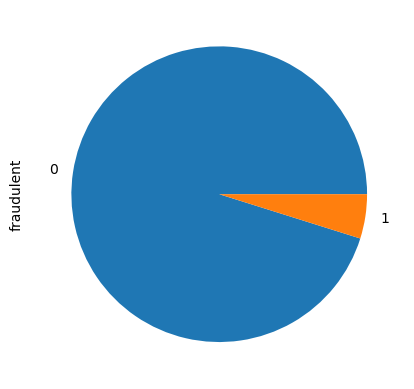

In [4]:
jobs.fraudulent.value_counts().plot(kind='pie')

In [5]:
jobs.fraudulent.value_counts()[0]/len(jobs)

0.9515659955257271

# Adat átalakítás

Csak a description oszlopot tartom meg.

In [6]:
jobs_last = jobs.drop(columns = ['job_id','title','location','department', 'telecommuting',
                             'salary_range','company_profile','requirements','benefits','employment_type',
                             'required_experience','required_education','industry','function','has_company_logo','has_questions'])
jobs_last.head()

,description,fraudulent
0,"Food52, a fast-growing, James Beard Award-winn...",0
1,Organised - Focused - Vibrant - Awesome!Do you...,0
2,"Our client, located in Houston, is actively se...",0
3,THE COMPANY: ESRI – Environmental Systems Rese...,0
4,JOB TITLE: Itemization Review ManagerLOCATION:...,0


In [7]:
jobs_last.fillna(" ", inplace = True)
jobs_last['word count'] = [len(i.split(' ')) for i in jobs_last['description']]

In [8]:
jobs_last.head()

,description,fraudulent,word count
0,"Food52, a fast-growing, James Beard Award-winn...",0,124
1,Organised - Focused - Vibrant - Awesome!Do you...,0,309
2,"Our client, located in Houston, is actively se...",0,50
3,THE COMPANY: ESRI – Environmental Systems Rese...,0,345
4,JOB TITLE: Itemization Review ManagerLOCATION:...,0,182


Átalakítom a szavak számokká. Minden szó egy sorszámot kap, így minden description egy vektor lesz.

In [9]:
from tensorflow.keras.preprocessing.text import one_hot, Tokenizer

In [10]:
max_features = 10000
t = Tokenizer(num_words = max_features)
# fit the tokenizer on the documents
t.fit_on_texts(list(jobs_last['description']))

In [11]:
encoded_docs = t.texts_to_sequences(list(jobs_last['description']))

In [12]:
sent_length = jobs_last['word count'].max()
embedded_docs=pad_sequences(encoded_docs,padding='pre',maxlen=sent_length)

In [13]:
print(embedded_docs)

[[   0    0    0 ...    1  431  175]
 [   0    0    0 ... 5360  817   23]
 [   0    0    0 ...    1  282 1335]
 ...
 [   0    0    0 ...  256  393    1]
 [   0    0    0 ...  706  202   92]
 [   0    0    0 ... 2948 1224   23]]


In [14]:
y = jobs_last.fraudulent.values
y = y.reshape(-1,1)
X = np.array(embedded_docs)

# Egyszerű Döntési fa

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.1, random_state= 101)

In [16]:
print("X_train shape: ",X_train.shape)
print("X_test shape : ",X_test.shape )
print("y_train shape: ",y_train.shape)
print("y_test shape : ",y_test.shape)

X_train shape:  (16092, 2074)
X_test shape :  (1788, 2074)
y_train shape:  (16092, 1)
y_test shape :  (1788, 1)


In [47]:
from sklearn import tree
clf = tree.DecisionTreeClassifier(criterion="gini",max_depth=15)
clf = clf.fit(X_train, y_train)

[Text(0.6488970588235294, 0.9285714285714286, 'X[2072] <= 6893.5\ngini = 0.092\nsamples = 16092\nvalue = [15310, 782]'),
 Text(0.4227941176470588, 0.7857142857142857, 'X[1589] <= 9061.5\ngini = 0.087\nsamples = 15771\nvalue = [15049, 722]'),
 Text(0.3161764705882353, 0.6428571428571429, 'X[2056] <= 9000.5\ngini = 0.087\nsamples = 15763\nvalue = [15047, 716]'),
 Text(0.19117647058823528, 0.5, 'X[2042] <= 9481.5\ngini = 0.085\nsamples = 15714\nvalue = [15014, 700]'),
 Text(0.11764705882352941, 0.35714285714285715, 'X[1954] <= 1.5\ngini = 0.084\nsamples = 15689\nvalue = [14999, 690]'),
 Text(0.058823529411764705, 0.21428571428571427, 'X[1964] <= 7168.5\ngini = 0.114\nsamples = 6790\nvalue = [6377, 413]'),
 Text(0.029411764705882353, 0.07142857142857142, 'gini = 0.11\nsamples = 6754\nvalue = [6361, 393]'),
 Text(0.08823529411764706, 0.07142857142857142, 'gini = 0.494\nsamples = 36\nvalue = [16, 20]'),
 Text(0.17647058823529413, 0.21428571428571427, 'X[2044] <= 9871.5\ngini = 0.06\nsamples 

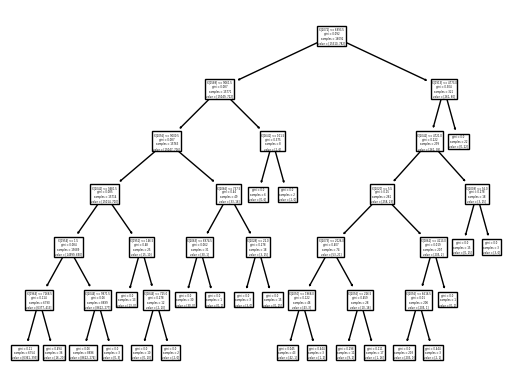

In [32]:
tree.plot_tree(clf)

In [48]:
y_pred = clf.predict(X_test)

In [49]:
from sklearn import metrics
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.9574944071588367


In [50]:
# Az előző kézzel.
acc=np.zeros((2,2))
for i in range(len(X_test)):
    out=clf.predict([X_test[i]])
    if out==0 and y_test[i]==0:
        acc[0,0]=acc[0,0]+1
    if out==1 and y_test[i]==0:
        acc[1,0]=acc[1,0]+1
    if out==0 and y_test[i]==1:
        acc[0,1]=acc[0,1]+1
    if out==1 and y_test[i]==1:
        acc[1,1]=acc[1,1]+1
print(acc)

[[1687.   59.]
 [  17.   25.]]


In [51]:
print(acc[1,1]/sum(acc[:,1]))

0.2976190476190476
